# Neural Network - with multiple inputs and neurons in hidden layer

In this note, I am going to train a neural network model with `gradient decent` estimation. This model will only have 2 direct inputs and 1 hidden layer with 3 neurons and logistic transform. The output layer will be activated with softmax.  

# Overview

This note will covere:
* Prepare the data
* Model and Cost function
* Backward propagation
* Momentum
* Code implementation

# Parepare the data

The dataset is generated by the scikit-learn make_circles method. It will contain 2 labels, blue $(t=1)$ and red $(t=0)$, where the red class is a circular distribution that surrounds the distribution of the blue class. 

In [1]:
# Python imports
import numpy as np  # Matrix and vector computation package
import sklearn.datasets # To generate the dataset
import matplotlib.pyplot as plt  # Plotting library
from matplotlib.colors import colorConverter, ListedColormap  # Some plotting functions
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
from matplotlib import cm  # Colormaps
# Allow matplotlib to plot inside this notebook
%matplotlib inline

# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)
# Generate the dataset
X, t = sklearn.datasets.make_circles(n_samples=100, shuffle=False, factor=0.4, noise=0.1)
T = np.zeros((100,2)) # Define target matrix
T[t==1,1] = 1
T[t==0,0] = 1
# Separate the red and blue points for plotting
x_red = X[t==0]
x_blue = X[t==1]

print('shape of X: {}'.format(X.shape))
print('shape of T: {}'.format(T.shape))

shape of X: (100, 2)
shape of T: (100, 2)


As you can see the plot below, it's not linear separatable. 

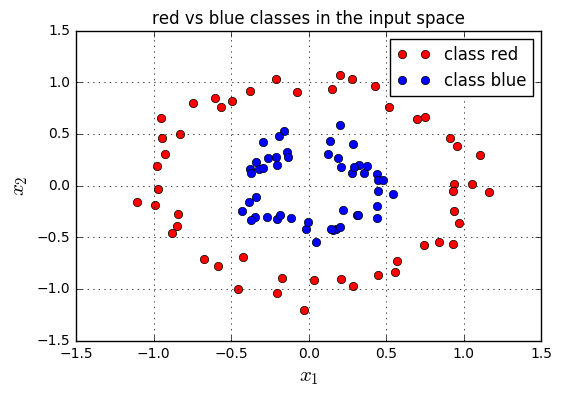

In [2]:
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red vs blue classes in the input space')
plt.show()

# Model and Cost Function

Model can be visualized as below:  
<p align="center">
<img src="https://raw.githubusercontent.com/weichetaru/weichetaru.github.com/master/notebook/machine-learning/img/SimpleANN04.png"></p>

### Input and Label
So for the input layer, we have 2 dimention inputs from N data points (Nx2): 
$$X =
\begin{bmatrix} 
x_{11} & x_{12} \\
\vdots & \vdots \\
x_{N1} & x_{N2}
\end{bmatrix}$$
And for output, we have 2 class (Nx2): 
$$T = \begin{bmatrix} 
t_{11} & t_{12}\\
\vdots & \vdots \\
t_{N1} & t_{N2} 
\end{bmatrix}$$

Where $t_{ij}=1$ if and only if the $i$-th input sample belongs to class $j$. So blue points are labelled T = [0 1] and red points are labelled T = [1 0].  

Note in the model we added a bias term $b$ to $X$ that has value +1 for all rows.

### Hidden Layer

The hidden layer has two set of parameters, $W_h$ (2x3) and bias term $b_h$ (1x3):

$$\begin{align}
W_h =
\begin{bmatrix} 
w_{h11} & w_{h12} & w_{h13} \\
w_{h21} & w_{h22} & w_{h23}
\end{bmatrix}
&& \mathbf{b}_h = 
\begin{bmatrix} 
b_{h1} & b_{h2} & b_{h3}
\end{bmatrix}
\end{align}$$

And we use logistic function for activation, hence $H$ (Nx3):

$$H = \sigma(z_h) =\sigma(X \cdot W_h + \mathbf{b}_h) = \frac{1}{1+e^{-(X \cdot W_h + \mathbf{b}_h)}} = \begin{bmatrix} 
h_{11} & h_{12} & h_{13} \\
\vdots & \vdots & \vdots \\
h_{N1} & h_{N2} & h_{N3}
\end{bmatrix}$$

#### Derivative of Logistic function

we will use the derivative of Logistic function in backward propagation. So writing down here in advance.  

**(1)**
$$\frac{\partial h_i}{\partial z_{hi}} = \frac{\partial \sigma(z_{hi})}{\partial z_{hi}} = \frac{\partial \frac{1}{1+e^{-z_{hi}}}}{\partial z_{hi}} = \frac{-1}{(1+e^{-z_{hi}})^2} *e^{-z_{hi}}*-1 = \frac{1}{1+e^{-z_{hi}}} \frac{e^{-z_{hi}}}{1+e^{-z_{hi}}} = \sigma(z_{hi}) * (1- \sigma(z_{hi})) =  h_i (1-h_i)$$

### Output layer

The output layer has two set of parameters, $W_o $ (3x2) and bias term $b_o$ (2x1):

$$\begin{align}
W_o =
\begin{bmatrix} 
w_{o11} & w_{o12} \\
w_{o21} & w_{o22} \\
w_{o31} & w_{o32}
\end{bmatrix}
&& \mathbf{b}_o = 
\begin{bmatrix} 
b_{o1} & b_{o2}
\end{bmatrix}
\end{align}$$

And we use `softmax function` for activation, hence $Y$ (Nx2): 

$$Y = \varsigma(H \cdot W_o + \mathbf{b}_o)
= \frac{e^{Z_o}}{\sum_{d=1}^C e^{\mathbf{z}_{od}}}
= \frac{e^{H \cdot W_o + \mathbf{b}_o}}{\sum_{d=1}^C e^{H \cdot \mathbf{w}_{od} + b_{od}}}
= \begin{bmatrix} 
y_{11} & y_{12}\\
\vdots & \vdots \\
y_{n1} & y_{n2} 
\end{bmatrix}$$

with $\varsigma$ the softmax function. In our example data, $C=2$ as we have 2 class red and blue. 

#### Derivative of Softmax function

we will use the derivative of Softmax function in backward propagation. So writing down here in advance.   

For $\Sigma_C = \sum_{d=1}^C e^{z_d} \, \text{for} \; c = 1 \cdots C$ so that $y_c = e^{z_c} / \Sigma_C$, ${\partial y_i}/{\partial z_j}$ of the output $y$ of the softmax function with respect to its input $z$ can be calculated as:  

**(2)**
$$
\begin{split}
\text{if} \; i = j :& \frac{\partial y_i}{\partial z_i} = \frac{\partial \frac{e^{z_i}}{\Sigma_C}}{\partial z_i} = \frac{e^{z_i}\Sigma_C - e^{z_i}e^{z_i}}{\Sigma_C^2} = \frac{e^{z_i}}{\Sigma_C}\frac{\Sigma_C - e^{z_i}}{\Sigma_C} = \frac{e^{z_i}}{\Sigma_C}(1-\frac{e^{z_i}}{\Sigma_C}) =  y_i (1 - y_i)\\
\text{if} \; i \neq j :& \frac{\partial y_i}{\partial z_j} = \frac{\partial \frac{e^{z_i}}{\Sigma_C}}{\partial z_j} = \frac{0 - e^{z_i}e^{z_j}}{\Sigma_C^2} = -\frac{e^{z_i}}{\Sigma_C} \frac{e^{z_j}}{\Sigma_C} = -y_i y_j
\end{split}
$$

### Code for forward step

We can at first code the functions for forward step.

In [3]:
# Define the logistic function. - for hidden layer activation. 
def logistic(z): 
    return 1 / (1 + np.exp(-z))

# Define the softmax function
def softmax(z): 
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

# Function to compute the hidden activations
def hidden_activations(X, Wh, bh):
    return logistic(X.dot(Wh) + bh)

# Define output layer feedforward
def output_activations(H, Wo, bo):
    return softmax(H.dot(Wo) + bo)

# Define the neural network function
def nn(X, Wh, bh, Wo, bo): 
    return output_activations(hidden_activations(X, Wh, bh), Wo, bo)

# Define the neural network prediction function that only returns
#  1 or 0 depending on the predicted class
def nn_predict(X, Wh, bh, Wo, bo): 
    return np.around(nn(X, Wh, bh, Wo, bo))

### Cost Function

The parameter set $w$ can be optimized  by maximizing the `likelihood`:

$$\underset{\theta}{\text{argmax}}\; \mathcal{L}(\theta|\mathbf{t},\mathbf{z})$$

The likelihood can be described as join distribution of $t\;and\;z\;$given $\theta$:

$$P(\mathbf{t},\mathbf{z}|\theta) = P(\mathbf{t}|\mathbf{z},\theta)P(\mathbf{z}|\theta)$$

We don't care the probability of $\mathbf{z}$ so 

$$\mathcal{L}(\theta|\mathbf{t},\mathbf{z}) = P(\mathbf{t}|\mathbf{z},\theta)$$

It can be written as $P(\mathbf{t}|\mathbf{z})$ for fixed $\theta$. Since each $t_i$ is dependent on the full $\mathbf{z}$, and only 1 class can be activated in the tt we can write:

$$P(\mathbf{t}|\mathbf{z}) = \prod_{i=c}^{C} P(t_c|\mathbf{z})^{t_c} = \prod_{i=c}^{C} \varsigma(\mathbf{z})_c^{t_c} = \prod_{i=c}^{C} y_c^{t_c}$$

Instead of maximizing this likelihood, it can also be done by minimizing the `negative log-likelihood`:

$$- log \mathcal{L}(\theta|\mathbf{t},\mathbf{z}) = \xi(\mathbf{t},\mathbf{z}) = - log \prod_{i=c}^{C} y_c^{t_c} = - \sum_{i=c}^{C} t_c \cdot log(y_c)$$

The cross-entropy error function $\xi$ for multiple class of sample size $n$ can be defined as:

$$\xi(T,Y) = \sum_{i=1}^n \xi(\mathbf{t}_i,\mathbf{y}_i) = - \sum_{i=1}^n \sum_{i=c}^{C} t_{ic} \cdot log( y_{ic})$$

Note $Y$ will be activated by `softmax` in output layer as we defined above. 

#### Derivative of the cross-entropy cost function for the softmax function

The derivative ${\partial \xi}/{\partial z_i}$ of the cost function with respect to the softmax input $z_i$ can be calculated as **(Note below use (2) the derivative of softmax function)**:  

**(3)** 
$$
\begin{split}
\frac{\partial \xi}{\partial z_i} & = - \sum_{j=1}^C \frac{\partial t_j log(y_j)}{\partial z_i}{} = - \sum_{j=1}^C t_j \frac{\partial log(y_j)}{\partial z_i} = - \sum_{j=1}^C t_j \frac{1}{y_j} \frac{\partial y_j}{\partial z_i} \\
& = - \frac{t_i}{y_i} \frac{\partial y_i}{\partial z_i} - \sum_{j \neq i}^C \frac{t_j}{y_j} \frac{\partial y_j}{\partial z_i}
= - \frac{t_i}{y_i} y_i (1-y_i) - \sum_{j \neq i}^C \frac{t_j}{y_j} (-y_j y_i) \\
& = - t_i + t_i y_i + \sum_{j \neq i}^C t_j y_i = - t_i + \sum_{j = 1}^C t_j y_i
= -t_i + y_i \sum_{j = 1}^C t_j \\
& = y_i - t_i
\end{split}
$$

# Backward propagation

During the backward step, what's important is to get the error gradient in each layer.  

### Gradient of output layer

The error gradient $\delta_{o}$ of this cost function at the softmax output layer is simply (from **(3)**):

$$\delta_{o} = \frac{\partial \xi}{\partial Z_o} = Y - T$$

As $Z_o = H \cdot W_o + \mathbf{b}_o$, so the output grandient over all $N$ samples is computed : 

$$\frac{\partial \xi}{\partial \mathbf{w}_{oj}} = 
\frac{\partial Z_{o}}{\partial \mathbf{w}_{oj}} \frac{\partial Y}{\partial Z_{o}} \frac{\partial \xi}{\partial Y} = 
\frac{\partial Z_{o}}{\partial w_{oji}} \frac{\partial \xi}{\partial Z_o} =
\sum_{i=1}^N h_{ij} (\mathbf{y}_i - \mathbf{t}_i) = 
\sum_{i=1}^N h_{ij} \delta_{oi}$$

In matrix form: 

$$\frac{\partial \xi}{\partial W_o} = H^T \cdot (Y-T) = H^T \cdot \delta_{o}$$

For bias term $b_o$: 

$$\frac{\partial \xi}{\partial \mathbf{b}_{o}} = \frac{\partial Z_{o}}{\partial \mathbf{b}_{o}} \frac{\partial Y}{\partial Z_{o}} \frac{\partial \xi}{\partial Y} = \sum_{i=1}^N 1 * (\mathbf{y}_i - \mathbf{t}_i) = \sum_{i=1}^N \delta_{oi}$$

### Gradient of hidden layer

The error gradient $\delta_{h}$ of this cost function at the hidden layer can be defined as:

$$\delta_{h} = \frac{\partial \xi}{\partial Z_h} = \frac{\partial H}{\partial Z_h} \frac{\partial \xi}{\partial H} = \frac{\partial H}{\partial Z_h} \frac{\partial Z_o}{\partial H} \frac{\partial \xi}{\partial Z_o}$$

As $Z_h = X \cdot W_h + \mathbf{b}_h$, $\delta_{h}$  will also result in a $N×3$ matrix. We use **(1)** and **(2)** to get result below.  
Note the gradients that backpropagate from the previous layer via the weighted connections are summed for each $h_{ij}$ 

$$\delta_{hij} = \frac{\partial \xi}{\partial z_{hij}} 
= \frac{\partial h_{ij}}{\partial z_{hij}} \frac{\partial \mathbf{z}_{oi}}{\partial h_{ij}} \frac{\partial \xi}{\partial \mathbf{z}_{oi}} 
= h_{ij} (1-h_{ij}) \sum_{k=1}^2 w_{ojk} (y_{ik}-t_{ik})
= h_{ij} (1-h_{ij}) [\delta_{oi} \cdot \mathbf{w}_{oj}^T]$$

In matrix form with notation $\circ$ for `elementwise product`: 

$$\delta_{h} = \frac{\partial \xi}{\partial Z_h} = H \circ (1 - H) \circ [\delta_{o} \cdot W_o^T]$$

The hidden layer gradient then can be defined as: 

$$\frac{\partial \xi}{\partial \mathbf{w}_{hj}} = 
\frac{\partial Z_{h}}{\partial \mathbf{w}_{hj}} \frac{\partial H}{\partial Z_{h}} \frac{\partial \xi}{\partial H} = 
\frac{\partial Z_{h}}{\partial \mathbf{w}_{hj}} \frac{\partial \xi}{\partial Z_h} =
\sum_{i=1}^N x_{ij} \delta_{hi}$$

For bias term $b_h$:

$$\frac{\partial \xi}{\partial \mathbf{b}_{h}} = \frac{\partial Z_{h}}{\partial \mathbf{b}_{h}} \frac{\partial H}{\partial Z_{h}} \frac{\partial \xi}{\partial H}
= \sum_{j=1}^N \delta_{hj}$$

### Code for cost and backward gradient


In [4]:
# Define the cost function
def cost(Y, T):
    return - np.multiply(T, np.log(Y)).sum()

# Define the error function at the output
def error_output(Y, T):
    return Y - T

# Define the gradient function for the weight parameters at the output layer
def gradient_weight_out(H, Eo): 
    return  H.T.dot(Eo)

# Define the gradient function for the bias parameters at the output layer
def gradient_bias_out(Eo): 
    return  np.sum(Eo, axis=0, keepdims=True)

# Define the error function at the hidden layer
def error_hidden(H, Wo, Eo):
    # H * (1-H) * (E . Wo^T)
    return np.multiply(np.multiply(H,(1 - H)), Eo.dot(Wo.T))

# Define the gradient function for the weight parameters at the hidden layer
def gradient_weight_hidden(X, Eh):
    return X.T.dot(Eh)

# Define the gradient function for the bias parameters at the output layer
def gradient_bias_hidden(Eh): 
    return  np.sum(Eh, axis=0, keepdims=True)

# Momentum

Model like this is highly unlikely to have convex cost functions and we might easily get a local minimum with gradient decent. Momentum is created to solve this. It's probably the most popular extension of the backprop algorithm.  

Momentum can be defined: 

$$\begin{split}
V(i+1) & = \lambda V(i) - \mu \frac{\partial \xi}{\partial \theta(i)} \\
\theta(i+1) & = \theta(i) + V(i+1)
\end{split}
$$

Where $V(i)$ is the velocity of the parameters at iteration $i$ and 0< $\lambda$ <1 shows how much the velocity decreases due to 'resistance' and $\mu$ the learning rate.  

Note here we are using previous $V(i)$ to update $V(i+1)$. The initial $V(0)$ should be nearly 0 so $V(1)$ is $\lambda$ (say, 0.9)*0 $-\mu \frac{\partial \xi}{\partial \theta(0)}$ (say, -1) = -1 and in iteration=2 the $V(i)$ is the same direction (say, -0.5) then $V(2)$ will become bigger (-0.9 - 0.5 = -1.4) and smaller if opposite direction (say. 0.5 -> -0.9 + 0.5 = -0.4).  

Essentially, it's just like we push a ball down a hill. The ball accumulates momentum as it rolls downhill, becoming faster and faster on the way. The same thing happens to our parameter updates: The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation.  

We can code backprop with momentum as below.

In [5]:
# Define the update function to update the network parameters over 1 iteration
def backprop_gradients(X, T, Wh, bh, Wo, bo):
    # Compute the output of the network
    # Compute the activations of the layers
    H = hidden_activations(X, Wh, bh)
    Y = output_activations(H, Wo, bo)
    # Compute the gradients of the output layer
    Eo = error_output(Y, T)
    JWo = gradient_weight_out(H, Eo)
    Jbo = gradient_bias_out(Eo)
    # Compute the gradients of the hidden layer
    Eh = error_hidden(H, Wo, Eo)
    JWh = gradient_weight_hidden(X, Eh)
    Jbh = gradient_bias_hidden(Eh)
    return [JWh, Jbh, JWo, Jbo]

def update_velocity(X, T, ls_of_params, Vs, momentum_term, learning_rate):
    # ls_of_params = [Wh, bh, Wo, bo]
    # Js = [JWh, Jbh, JWo, Jbo]
    Js = backprop_gradients(X, T, *ls_of_params)
    return [momentum_term * V - learning_rate * J for V,J in zip(Vs, Js)]

def update_params(ls_of_params, Vs):
    # ls_of_params = [Wh, bh, Wo, bo]
    # Vs = [VWh, Vbh, VWo, Vbo]
    return [P + V for P,V in zip(ls_of_params, Vs)]

# Code Implementaion

In [6]:
# Run backpropagation
# Initialize weights and biases
init_var = 0.1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var
# Parameters are already initilized randomly with the gradient checking
# Set the learning rate
learning_rate = 0.02
momentum_term = 0.9

# define the velocities Vs = [VWh, Vbh, VWo, Vbo]
Vs = [np.zeros_like(M) for M in [Wh, bh, Wo, bo]]

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 300  # number of gradient descent updates
lr_update = learning_rate / nb_of_iterations # learning rate update rule
ls_costs = [cost(nn(X, Wh, bh, Wo, bo), T)]  # list of cost over the iterations
for i in range(nb_of_iterations):
    # Update the velocities and the parameters
    Vs = update_velocity(X, T, [Wh, bh, Wo, bo], Vs, momentum_term, learning_rate)
    Wh, bh, Wo, bo = update_params([Wh, bh, Wo, bo], Vs)
    ls_costs.append(cost(nn(X, Wh, bh, Wo, bo), T))

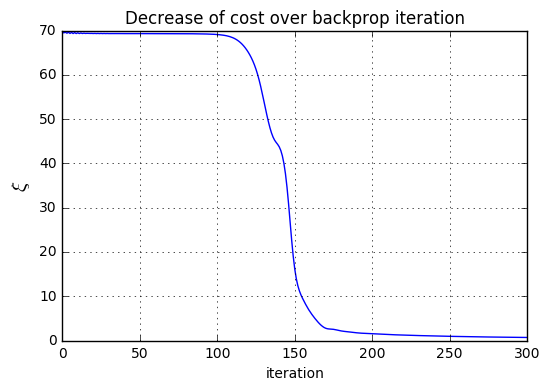

In [7]:
# Plot the cost over the iterations
plt.plot(ls_costs, 'b-')
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.grid()
plt.show()

### Visualization of the trained classifier

The classifier we just trianed is circled around and between the blue and red class. It's non-linear and hence be able to correctly classify red and blue.  

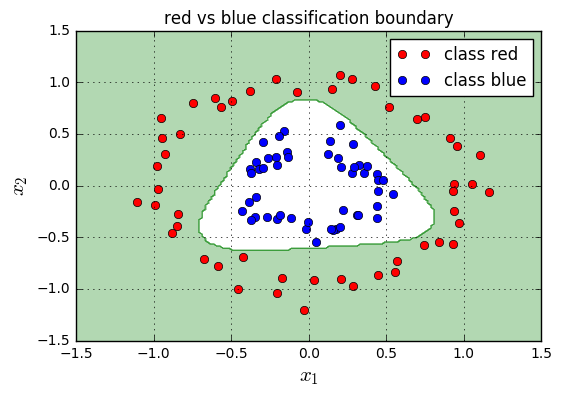

In [8]:
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 200
xs1 = np.linspace(-2, 2, num=nb_of_xs)
xs2 = np.linspace(-2, 2, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = nn_predict(np.asmatrix([xx[i,j], yy[i,j]]), Wh, bh, Wo, bo)
        classification_plane[i,j] = pred[0,0]
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('w', alpha=0.30),
        colorConverter.to_rgba('g', alpha=0.30)])

# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red vs blue classification boundary')
plt.show()

### Transformation of the input domain

You can see from the plot below. the 2-dimentions input have been project into 3-dimension space (hidden layer) and become liner separable.

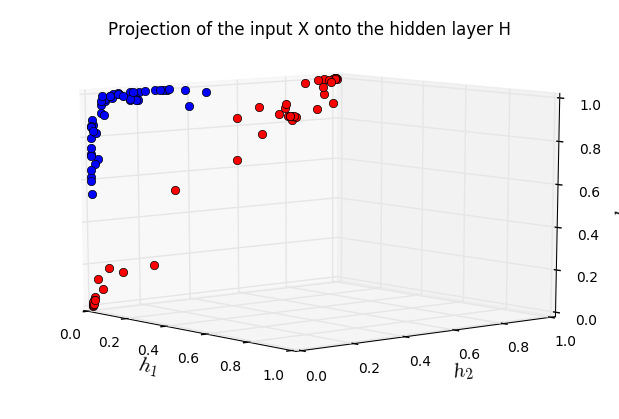

In [9]:
# Plot the projection of the input onto the hidden layer

# Define the projections of the blue and red classes
H_blue = hidden_activations(x_blue, Wh, bh)
H_red = hidden_activations(x_red, Wh, bh)
# Plot the error surface
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(np.ravel(H_blue[:,2]), np.ravel(H_blue[:,1]), np.ravel(H_blue[:,0]), 'bo')
ax.plot(np.ravel(H_red[:,2]), np.ravel(H_red[:,1]), np.ravel(H_red[:,0]), 'ro')
ax.set_xlabel('$h_1$', fontsize=15)
ax.set_ylabel('$h_2$', fontsize=15)
ax.set_zlabel('$h_3$', fontsize=15)
ax.view_init(elev=10, azim=-40)
plt.title('Projection of the input X onto the hidden layer H')
plt.grid()
plt.show()

The sample codes in this note come from [peterroelants.github.io](http://peterroelants.github.io/) where providing more details on neural netwrok and deep learning. It's very informative and highly recommanded. Here is more like my personal memo.